# Does harassment have a chilling effect on newcomer participation in Wikipedia?

## Code

In [130]:
% matplotlib inline
import pandas as pd
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as sm
import requests

### Load Data for 2015 newcomers

In [9]:
# load no bot, non admin scord diffs for 2015
d1 = pd.read_csv("../../data/figshare/scored/comments_user_2015.tsv.gz", sep = "\t", compression = "gzip")
d1['ns'] = 'user'
del d1['comment']
del d1['raw_comment']
d1 = d1.query("bot == 0 and admin == 0")

d2 = pd.read_csv("../../data/figshare/scored/comments_article_2015.tsv.gz", sep = "\t", compression = "gzip")
d2['ns'] = 'article'
del d2['comment']
del d2['raw_comment']
d2 = d2.query("bot == 0 and admin == 0")

df_annotated = pd.concat([d1,d2])
df_annotated['timestamp'] = pd.to_datetime(df_annotated['timestamp'])

In [6]:
# registration times of all editors who registered in 2015 and who made and edit
df_user_start = pd.read_csv("../../data/retention/user_start.tsv", "\t")
df_user_start = df_user_start.query("user_registration != 'null'")
del df_user_start['user_registration']
df_user_start['registration_day'] = pd.to_datetime(df_user_start['registration_day'], format = '%Y%m%d')
df_user_start['first_edit_day'] = pd.to_datetime(df_user_start['first_edit_day'], format = '%Y%m%d')
df_user_start = df_user_start.query("registration_day >= '2015-01-01'")

/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
# load edits per day in 2015 for new users in 2015
df_edits = pd.read_csv("../../data/retention/daily_edit_counts.tsv", "\t")
df_edits['timestamp'] = pd.to_datetime(df_edits['day'].apply(lambda x: str(x)))
df_edits = df_edits.merge(df_user_start[['user_id']], how = 'inner', on = 'user_id')
df_edits = df_edits.query("timestamp >= '2015-01-01'")

KeyError: "['user_text'] not in index"

In [29]:
# genders
df_gender = pd.read_csv("../../data/misc/genders.tsv", "\t")

In [32]:
# create df of consolidated user level features
df_user = df_edits.drop_duplicates(subset = 'user_text')[['user_text']]
df_user = df_user.merge(df_gender, on = 'user_text', how = "left")[['user_text', 'gender']]
df_user['gender'] = df_user['gender'].fillna('unknown')
df_user = df_user.merge(df_user_start, on = 'user_text', how = "inner")[['user_text', 'gender', 'registration_day', 'first_edit_day']]
del df_user_start
del df_gender

### Visualizations

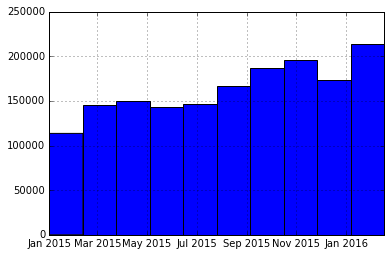

In [35]:
# hist of active user days for 2015 newcomers
df_edits['timestamp'].hist()

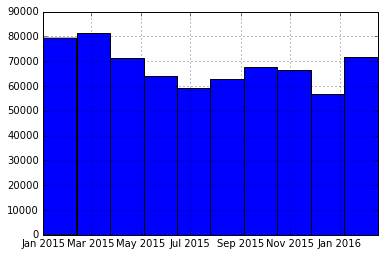

In [36]:
# hist of user registration times of editors who made at least one edit in 2015
df_user['registration_day'].hist()

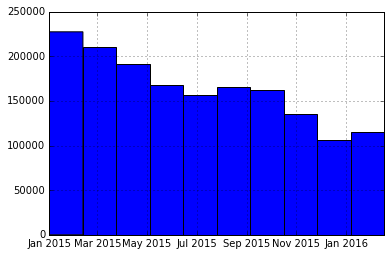

In [39]:
# hist of newcomer edits by month newcomer registered
df_edits.merge(df_user, on = 'user_text')['registration_day'].hist()

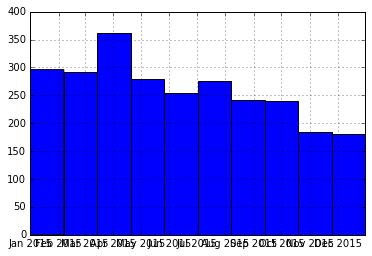

In [40]:
# attacks made in 2015 by registration date
df_annotated.query("pred_attack_score > 0.5").merge(df_user, on = 'user_text')['registration_day'].hist()

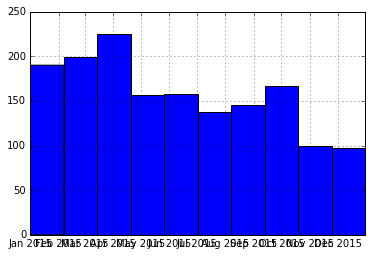

In [42]:
# attacks received by newcomer registration date
df_annotated.query("pred_attack_score > 0.5 and ns == 'user'").merge(df_user, left_on = 'page_title', right_on = 'user_text')['registration_day'].hist()

In [43]:
df_user['gender'].value_counts()

unknown    669537
male         8599
female       2378
Name: gender, dtype: int64

### Reformat Data

In [44]:
# map data frames into dictionaries keyed by user
def gb_to_dict(gb):
    return { i:k for i,k in gb}

df_annotated_user_text_groups = gb_to_dict(df_annotated.groupby("user_text"))
df_annotated_page_title_groups =  gb_to_dict(df_annotated.query("ns == 'user'").groupby("page_title"))
df_edits_groups =  gb_to_dict(df_edits.groupby("user_text"))
df_user_groups =  gb_to_dict(df_user.groupby("user_text"))

In [49]:
# collect User objects 
class User():
    def __init__(self, user_text, df_annotated_user_text_groups, df_annotated_page_title_groups, df_edits_groups, df_user_groups):
        self.user_text = user_text
        self.df_activity =  df_edits_groups.get(user_text, None)
        self.df_comments_made =  df_annotated_user_text_groups.get(user_text, None)
        self.df_comments_received = df_annotated_page_title_groups.get(user_text, None)
        if self.df_comments_received is not None:
            self.df_comments_received = self.df_comments_received.query("ns == 'user' and user_text != page_title")
        self.gender = df_user_groups[user_text]['gender'].iloc[0]
        self.registration_day = df_user_groups[user_text]['registration_day'].iloc[0]
        self.first_edit_day = df_user_groups[user_text]['first_edit_day'].iloc[0]

### RQ1: Does being harassed in the first month make newcomers less likely to make edits in the second month?

#### Select newcomer sample

In [51]:
# select subset of users to regress on, only consider new comers who registered between Jan and Oct
# combine a random sample of newcomers with all newcomers who got attacked 
n_random = 1000
threshold = 0.425
new_user_texts = df_user.query("registration_day <= '2015-10-01'")[['user_text']]
print("Total New Users: ", new_user_texts.shape[0])

df_bad_comments = df_annotated.query("pred_attack_score > %f or pred_aggression_score > %f or pred_toxicity_score > %f" % (threshold, threshold, threshold))
attacked_users = df_bad_comments.query("ns == 'user' and user_text != page_title").drop_duplicates(['page_title'])
attacked_users = attacked_users[['page_title']]
new_attacked_users = attacked_users.merge(new_user_texts, right_on = 'user_text', left_on = 'page_title')[['user_text']]
print("Total New Harrassed Users: ", new_attacked_users.shape[0])


random_new_user_texts_sample = new_user_texts.sample(n_random)

new_user_texts_sample = pd.concat([random_new_user_texts_sample, new_attacked_users])['user_text']

user_objects = [User( user_text,
                      df_annotated_user_text_groups,
                      df_annotated_page_title_groups,
                      df_edits_groups,
                      df_user_groups) 
                for user_text in new_user_texts_sample]

Total New Users:  460668
Total New Harrassed Users:  735


#### Feature extraction

In [61]:
def select_timespan(user,  activity, t):
    start = user.registration_day + relativedelta(months=(t-1))
    stop = user.registration_day + relativedelta(months= t)
    activity = activity[activity['timestamp'] < stop]
    activity = activity[activity['timestamp'] >= start]
    return activity

def count_edits(user, t):
    activity = user.df_activity
    activity = select_timespan(user,  activity, t)
    return activity['n'].sum()

def count_days_active(user, t):
    activity = user.df_activity
    activity = select_timespan(user,  activity, t)
    return len(activity.timestamp.unique())

def count_score_received_above_threshold(user, score, threshold, t):
    if user.df_comments_received is None:
        return 0
    
    comments = user.df_comments_received
    comments = select_timespan(user,  comments, t)
    return (comments[score] > threshold).sum()

def count_score_made_above_threshold(user, score, threshold, t):
    if user.df_comments_made is None:
        return 0
    
    comments = user.df_comments_made
    comments = select_timespan(user,  comments, t)
    return (comments[score] > threshold).sum()

def is_female(u):
    return u.gender == 'female'

def is_male(u):
    return u.gender == 'male'

df_reg = pd.DataFrame({
        'user_text' : [u.user_text for u in user_objects],
        'is_female' : [is_female(u) for u in user_objects],
        'is_male' : [is_male(u) for u in user_objects],
        't1_num_edits' : [count_edits(u, 1) for u in user_objects],
        't2_num_edits' : [count_edits(u, 2) for u in user_objects],
        't1_num_days_active' : [count_days_active(u, 1) for u in user_objects],
        't2_num_days_active' : [count_days_active(u, 2) for u in user_objects],
        't1_num_attacks_received' : [count_score_received_above_threshold(u, 'pred_attack_score',  threshold, 1) for u in user_objects],
        't1_num_aggression_received' : [count_score_received_above_threshold(u,  'pred_aggression_score',  threshold, 1) for u in user_objects],
        't1_num_toxicity_received' : [count_score_received_above_threshold(u,  'pred_toxicity_score',  threshold, 1) for u in user_objects],
        't1_num_attacks_made' : [count_score_made_above_threshold(u, 'pred_attack_score',  threshold, 1) for u in user_objects],
        't1_num_aggresssion_made': [count_score_made_above_threshold(u,  'pred_aggression_score',  threshold, 1) for u in user_objects],
        't1_num_toxicity_made': [count_score_made_above_threshold(u,  'pred_toxicity_score',  threshold, 1) for u in user_objects],

    })

df_reg.shape

(1735, 13)

In [62]:
df_reg['t1_active'] = df_reg['t1_num_edits'] > 0
df_reg['t2_active'] = df_reg['t2_num_edits'] > 0
df_reg['t1_harassment_received'] = (df_reg['t1_num_attacks_received'] > 0) | (df_reg['t1_num_aggression_received'] > 0) | (df_reg['t1_num_toxicity_received'] > 0)
df_reg['t1_harassment_made'] = (df_reg['t1_num_attacks_made'] > 0) | (df_reg['t1_num_aggresssion_made'] > 0) | (df_reg['t1_num_toxicity_made'] > 0)

(1735, 17)

In [ ]:
df_reg.index = df_reg.user_text
del df_reg['user_text']
df_reg = df_reg.astype(int)
df_reg.shape

In [109]:
# only consider users who made at least one edit in the first month afer registering (active)
df_reg_active = df_reg.query('t1_active ==1')
print(df_reg_active.shape[0])

1659


In [110]:
# only consider  users who made at least one edit in the first month afer registering and did not harass anyone (active, friendly)
df_reg_active_friendly = df_reg.query('t1_active ==1 and t1_harassment_made == 0')
print(df_reg_active_friendly.shape[0])

1579


In [ ]:
# only consider  users who made at least one edit in the first month afer registering,
# did not harass anyone, and did not vandalize (active, friendly, goodfaith)
df_reg_active_friendly_goodfaith = df_reg.query('t1_active ==1 and t1_harassment_made == 0 and t1_vandalism_made == 0')
print(df_reg_acitive_friendly.shape[0])

#### Modeling

Does receiving harassment in t1 make you less likely to make an edit t2?

In [91]:
result = sm.ols(formula="t2_active ~ t1_harassment_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,0.1469,0.011,12.959,0.000,0.125 0.169
t1_harassment_received,0.0803,0.021,3.802,0.000,0.039 0.122


In [92]:
result = sm.logit(formula="t2_active ~ t1_harassment_received", data=df_reg3).fit()
result.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.451472
         Iterations 6


,coef,std err,z,P>|z|,[95.0% Conf. Int.]
Intercept,-1.7589,0.086,-20.550,0.000,-1.927 -1.591
t1_harassment_received,0.5352,0.142,3.759,0.000,0.256 0.814


Regress activity measure in t2 on activity measure in t1  

In [94]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.6304,0.074,-8.496,0.000,-0.776 -0.485
t1_num_days_active,0.5801,0.018,32.478,0.000,0.545 0.615


Regress activity measure in t2 on activity measure in t1 a measure of harassment

In [96]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active + t1_num_attacks_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.5105,0.076,-6.752,0.000,-0.659 -0.362
t1_num_days_active,0.6104,0.018,33.431,0.000,0.575 0.646
t1_num_attacks_received,-0.8647,0.135,-6.390,0.000,-1.130 -0.599


In [98]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active + t1_num_aggression_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.4814,0.076,-6.334,0.000,-0.630 -0.332
t1_num_days_active,0.6164,0.018,33.660,0.000,0.581 0.652
t1_num_aggression_received,-0.9076,0.128,-7.083,0.000,-1.159 -0.656


In [100]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active + t1_num_toxicity_received", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.5692,0.076,-7.506,0.000,-0.718 -0.420
t1_num_days_active,0.5846,0.018,32.778,0.000,0.550 0.620
t1_num_toxicity_received,-0.6116,0.169,-3.614,0.000,-0.944 -0.280


Regress activity measure in t2 on activity measure in t1 multiple measures of harassment: Does not work since the data is harassment measures are highly correlated.

In [101]:
from scipy.stats import pearsonr 
print(pearsonr(df_reg3['t1_num_attacks_received'] , df_reg3['t1_num_aggression_received']))
print(pearsonr(df_reg3['t1_num_toxicity_received'] , df_reg3['t1_num_aggression_received']))
print(pearsonr(df_reg3['t1_num_toxicity_received'] , df_reg3['t1_num_attacks_received']))

(0.86488325520199183, 0.0)
(0.47212670216702707, 1.0291539426236762e-85)
(0.46513519636080747, 6.3574362535439e-83)


Interact with gender

In [102]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active + is_female", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.6335,0.074,-8.536,0.000,-0.779 -0.488
t1_num_days_active,0.5779,0.018,32.225,0.000,0.543 0.613
is_female,0.6783,0.512,1.326,0.185,-0.325 1.682


In [103]:
result = sm.ols(formula="t2_num_days_active ~ t1_num_days_active + t1_num_aggression_received * is_female", data=df_reg3).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,-0.4896,0.076,-6.442,0.000,-0.639 -0.341
t1_num_days_active,0.6133,0.018,33.414,0.000,0.577 0.649
t1_num_aggression_received,-0.8855,0.129,-6.861,0.000,-1.139 -0.632
is_female,1.6843,0.709,2.376,0.018,0.294 3.074
t1_num_aggression_received:is_female,-1.7825,1.003,-1.777,0.076,-3.750 0.185


Only consider new comers whose edits in the first month were not damaging
1. get all main ns edits in the first month
2. score each of them via ores

In [175]:
df_reg3.head()

,is_female,is_male,t1_num_aggression_received,t1_num_aggresssion_made,t1_num_attacks_made,t1_num_attacks_received,t1_num_days_active,t1_num_edits,t2_num_days_active,t2_num_edits,t1_active,t2_active,t1_harassment_received,t1_harassment_made
user_text,,,,,,,,,,,,,,
Coonass5639,0,0,0,0,0,0,1,1,0,0,1,0,0,0
Webdynamika,0,0,0,0,0,0,1,1,0,0,1,0,0,0
Jefland2003,0,0,0,0,0,0,1,4,0,0,1,0,0,0
Rasheed jaber,0,0,0,0,0,0,1,2,0,0,1,0,0,0
Glorious Japan Forever VI,0,0,0,0,0,0,1,2,0,0,1,0,0,0


In [131]:
def get_user_contribs(uname, start, end, uclimit = 500):
    params = {'action': 'query',
           'format': 'json',
           'list' : 'usercontribs',
           'uclimit': uclimit,
           'ucdir': 'newer',
           'ucprop': 'oresscores|ids|timestamp|title',
           'ucuser': uname,
           'ucstart': start,
           'ucend': end,
          }
    
    r = requests.get('http://en.wikipedia.org/w/api.php', params=params).json()
    try:
        r = requests.get('http://en.wikipedia.org/w/api.php', params=params).json()
        print(r)
        return r["query"]['usercontribs']
    except:
        print("Error getting contribs: ", uname)
        return []

In [132]:
user_contribs_t1 = {}

for user in user_objects:
    start = user.registration_day 
    end = user.registration_day + relativedelta(months=1)
    user_contribs_t1[user.user_text] = get_user_contribs(user.user_text, str(start), str(end))
    break
    

{'query': {'usercontribs': [{'oresscores': {'damaging': {'false': 0.185, 'true': 0.815}}, 'pageid': 318620, 'user': 'Martinlanza', 'userid': 26274229, 'title': 'Alexandra Palace', 'timestamp': '2015-09-16T13:47:14Z', 'revid': 681312508, 'parentid': 680528205, 'ns': 0}, {'oresscores': {'damaging': {'false': 0.29, 'true': 0.71}}, 'pageid': 318620, 'user': 'Martinlanza', 'userid': 26274229, 'title': 'Alexandra Palace', 'timestamp': '2015-09-16T13:51:32Z', 'revid': 681313074, 'parentid': 681312508, 'ns': 0}, {'oresscores': {'damaging': {'false': 0.384, 'true': 0.616}}, 'pageid': 318620, 'user': 'Martinlanza', 'userid': 26274229, 'title': 'Alexandra Palace', 'timestamp': '2015-09-16T14:02:52Z', 'revid': 681314409, 'parentid': 681313074, 'ns': 0}]}, 'batchcomplete': ''}


In [127]:
str(start)

'2015-09-16 00:00:00'